In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from risparser import convert_ris_to_csv

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Read files

In [2]:
# convert RIS files to CSV
raw_files = [raw_files for raw_files in os.listdir("raw") if raw_files.endswith(".ris")]
os.makedirs("csv", exist_ok=True)
for ris_file in raw_files:
    ris_fp = os.path.join("raw", ris_file)
    csv_fp = os.path.join("csv", os.path.splitext(ris_file)[0] + ".csv")
    convert_ris_to_csv(ris_fp, csv_fp)

Input file: raw/schoot-lgmm-ptsd-initial.ris
Number of articles: 6187
Export file: csv/schoot-lgmm-ptsd-initial.csv
Input file: raw/schoot-lgmm-ptsd-included-1.ris
Number of articles: 363
Export file: csv/schoot-lgmm-ptsd-included-1.csv
Input file: raw/schoot-lgmm-ptsd-included-3.ris
Number of articles: 8
Export file: csv/schoot-lgmm-ptsd-included-3.csv
Input file: raw/schoot-lgmm-ptsd-included-2.ris
Number of articles: 38
Export file: csv/schoot-lgmm-ptsd-included-2.csv


In [3]:
# full dataset
df_all = pd.read_csv("csv/schoot-lgmm-ptsd-initial.csv")
# included after abstract screening
df_abstract_screening = pd.read_csv("csv/schoot-lgmm-ptsd-included-1.csv")
# included after full text screening
df_included = pd.read_csv("csv/schoot-lgmm-ptsd-included-2.csv")

## Clean datasets

### Step 1: Add `record_id`, `label_included` & `label_abstract_screening`

In [4]:
# titles of inclusions after full text screening
included_title = df_included["title"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower()

# titles of inclusions after abstract screening
abstract_screening_title = df_abstract_screening["title"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower()

In [5]:
# check if included records are missing from the full dataset
df_all = df_all.assign(title_clean=df_all["title"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower())

print("Papers included, missing from full dataset:              ", (~included_title.isin(df_all["title_clean"])).sum(), "\n")
print("Papers in abstract screening, missing from full dataset: ", (~abstract_screening_title.isin(df_all["title_clean"])).sum(), "\n")

Papers included, missing from full dataset:               0 

Papers in abstract screening, missing from full dataset:  2 



In [6]:
# add missing papers
df_all = df_all.append(df_abstract_screening[~abstract_screening_title.isin(df_all["title_clean"])], ignore_index=True)
df_all.iloc[-2:,-1] = df_all.iloc[-2:].title.str.replace("[^A-Za-z0-9]", "", regex=True).str.lower()

# add record id
df_all.insert(0, "record_id", df_all.index + 1)

In [7]:
# add labels
#label_dir_included = df_all["title_clean"].isin(dir_included_title)
label_included = df_all["title_clean"].isin(included_title)
label_abstract_screening = (df_all["title_clean"].isin(abstract_screening_title)) | label_included
df_all = df_all.assign(label_included=label_included.astype(int), label_abstract_screening=label_abstract_screening.astype(int))

### Step 2: Find duplicate records and add `duplicate_record_id`

In [8]:
# find duplicates based on title
df_all.sort_values(["label_included", "label_abstract_screening"], ascending=False, inplace=True)
duplicate = df_all.duplicated(subset=["title_clean"]) & ~df_all.title_clean.isnull()
df_all["duplicate_record_id"] = np.where(duplicate, 1, np.nan)

In [9]:
# if duplicate, duplicate_id indicates the corresponding record_id, otherwise NA
for i in range(len(df_all)):
    if df_all.loc[i, "duplicate_record_id"] == 1:
        df_all.loc[i, "duplicate_record_id"] = df_all.loc[~duplicate & df_all.loc[~duplicate, "title_clean"].isin([df_all.loc[i, "title_clean"]]), "record_id"].tolist()
df_all.duplicate_record_id = df_all.duplicate_record_id.astype("Int64")

### Step 3: Impute missing title and fix unexpected value/mark

In [10]:
# impute missing title with secondary title
df_all.fillna({"title": df_all["secondary_title"]}, inplace=True)

In [11]:
# fix unexpected value/mark
df_all.loc[df_all.year == 0, "year"] = np.nan
df_all["authors"] = df_all["authors"].str.replace("[\\[']", "", regex=True).str.replace("\\]", "", regex=True)
df_all["keywords"] = df_all["keywords"].str.replace("[\\[']", "", regex=True).str.replace("\\]", "", regex=True)

### Step 4: Sort by orginal order and retain useful columns

In [12]:
df_all.sort_values("record_id", inplace=True)
df_all = df_all[["record_id", "title", "abstract", "keywords", "authors", "year", "date", "doi", "label_included", "label_abstract_screening", "duplicate_record_id"]]

## Export datasets

In [13]:
Path("output").mkdir(parents=True, exist_ok=True)
df_all.to_csv("output/van_de_Schoot_2017.csv", index=False)

## Dataset statistics

### Summary of inclusions and exclusions

In [14]:
n = len(df_all)
n_dup = (~df_all["duplicate_record_id"].isna()).sum()
n_wo_dup = n - n_dup
n_inc = df_all.loc[df_all.duplicate_record_id.isna(), "label_included"].sum()
n_inc_abs = df_all.loc[df_all.duplicate_record_id.isna(), "label_abstract_screening"].sum()
n_exc = n_wo_dup - n_inc
n_exc_abs = n_wo_dup - n_inc_abs
n_exc_full = n_inc_abs - n_inc

print("Total number of papers:                     ", n, "(includes", n_dup, "duplicates) \n")
print("Total number of papers without duplicates:  ", n_wo_dup, "\n\n")
print("Following statistics calculated without duplicates: \n")
print("Total number of EXCLUSIONS:                 ", n_exc, "\n")
print("Total EXCLUSIONS after abstract screening:  ", n_exc_abs, "\n")
print("Total INCLUSIONS after abstract screening:  ", n_inc_abs, "\n")
print("Total EXCLUSIONS after full text screening: ", n_exc_full, "\n")
print("Total INCLUSIONS after full text screening: ", n_inc, " (", round(100*n_inc/n_wo_dup, 2), "% )\n")

Total number of papers:                      6189 (includes 407 duplicates) 

Total number of papers without duplicates:   5782 


Following statistics calculated without duplicates: 

Total number of EXCLUSIONS:                  5744 

Total EXCLUSIONS after abstract screening:   5426 

Total INCLUSIONS after abstract screening:   356 

Total EXCLUSIONS after full text screening:  318 

Total INCLUSIONS after full text screening:  38  ( 0.66 % )



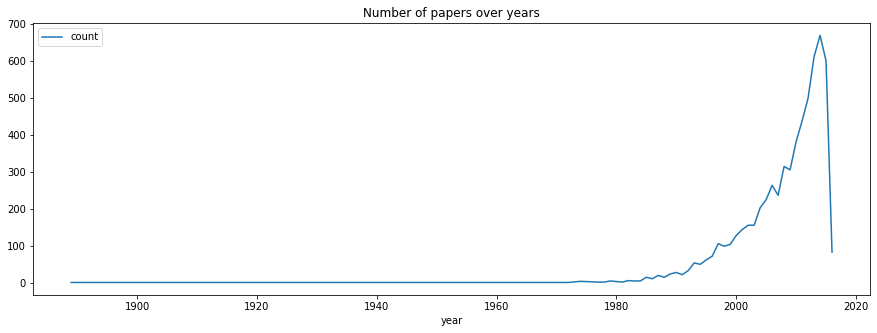

In [15]:
# number of papers over years
df_all.groupby("year").size().reset_index(name="count").set_index("year").plot(figsize=(15,5))
plt.title("Number of papers over years")
plt.show()

### Missingness of title and abstract

In [16]:
print("Number of papers with missing title:              ", df_all["title"].isna().sum(), "\n")
print("Number of papers with missing abstract:           ", df_all["abstract"].isna().sum(), "\n")
print("Number of papers with missing title AND abstract: ", (df_all["title"].isna() & df_all["abstract"].isna()).sum(), "\n")
print("Number of papers with missing title OR abstract:  ", (df_all["title"].isna() | df_all["abstract"].isna()).sum(), "\n\n")

Number of papers with missing title:               5 

Number of papers with missing abstract:            764 

Number of papers with missing title AND abstract:  5 

Number of papers with missing title OR abstract:   764 




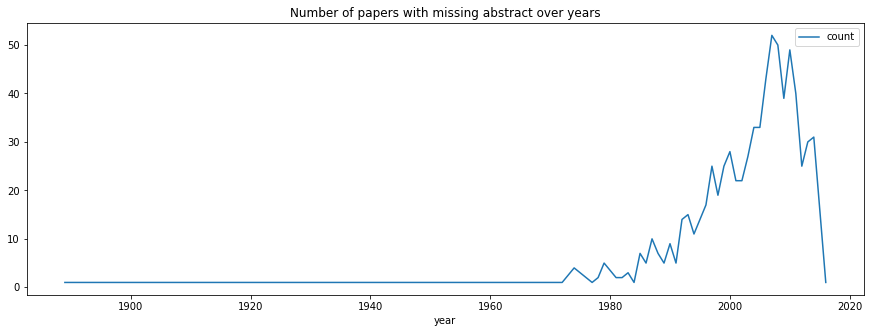

In [17]:
# missing abstract over years
df_all["abstract"].isna().groupby(df_all["year"]).sum().astype(int).\
reset_index(name="count").set_index("year").\
plot(figsize=(15,5))
plt.title("Number of papers with missing abstract over years")
plt.show()

### Word cloud for titles and abstracts

There are 634598 words in the combination of all titles. 

There are 8357654 words in the combination of all abstracts. 



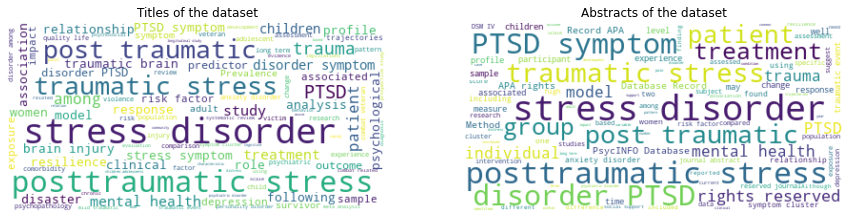

In [18]:
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update(["effect", "effects", "result", "results", "conclusion", "conclusions"])

# create word cloud text
title_text = " ".join(word for word in df_all.title.dropna())
abstract_text = " ".join(word for word in df_all.abstract.dropna())
print ("There are {} words in the combination of all titles.".format(len(title_text)), "\n")
print ("There are {} words in the combination of all abstracts.".format(len(abstract_text)), "\n")

# generate word cloud images
title_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(title_text)
abstract_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(abstract_text)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 15])
ax1.imshow(title_wordcloud, interpolation="bilinear")
ax1.set_title("Titles of the dataset")
ax1.axis("off")
ax2.imshow(abstract_wordcloud, interpolation="bilinear")
ax2.set_title("Abstracts of the dataset")
ax2.axis("off")
plt.show()